In [43]:
#LSTM+CNN

import re
import os

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)


device: cpu


In [44]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt"
assert os.path.exists(DATA_PATH), "경로가 올바른지 확인하세요."


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
def load_wisdm_raw(raw_path):
    rows = []
    with open(raw_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            # 콤마/공백 섞여 들어오는 경우가 있어 통합 정규화
            parts = re.split('[, ]+', line)
            if len(parts) < 6:
                continue
            user = parts[0]
            activity = parts[1]
            x = parts[-3]
            y = parts[-2]
            z = parts[-1].replace(';','')
            timestamp = ''.join(parts[2:-3])  # 남은 부분을 timestamp로 묶음
            try:
                rows.append([user, activity, int(timestamp), float(x), float(y), float(z)])
            except:
                # 형식 틀어진 라인은 스킵
                continue
    df = pd.DataFrame(rows, columns=['user','activity','timestamp','x','y','z'])
    df = df.sort_values(['user','activity','timestamp']).reset_index(drop=True)
    return df

df = load_wisdm_raw(DATA_PATH)
print(df.shape)
df


(1086465, 6)


,user,activity,timestamp,x,y,z
0,1,Downstairs,6552942304000,-0.15,9.15,-0.34
1,1,Downstairs,6552992292000,0.11,9.19,2.76
2,1,Downstairs,6553042310000,-4.06,7.40,4.02
3,1,Downstairs,6553092298000,-2.87,7.93,3.21
4,1,Downstairs,6553142347000,-0.19,10.04,4.82
...,...,...,...,...,...,...
1086460,9,Walking,9614392347000,12.37,7.70,3.49
1086461,9,Walking,9614442335000,10.84,6.78,1.14
1086462,9,Walking,9614492292000,8.01,5.05,-0.04
1086463,9,Walking,9614542341000,5.86,4.21,-1.18


In [46]:
def make_windows_userwise_mode(df: pd.DataFrame, window_size=128, step=32):
    """
    df: columns = ['user','activity','timestamp','x','y','z']
    window_size: 한 윈도우 길이
    step: 윈도우 이동 간격
    return: X(np.ndarray: [num_win, window_size, 3]), y(np.ndarray: [num_win])
    """
    assert {'user','activity','timestamp','x','y','z'} <= set(df.columns)

    X_list, y_list = [], []

    # user별 시계열 정렬 후 윈도우링
    for user, g in df.groupby('user'):
        g = g.sort_values('timestamp')
        arr = g[['x','y','z']].values          # (N, 3)
        labels = g['activity'].values          # (N,)
        n = len(arr)
        if n < window_size:
            continue

        for start in range(0, n - window_size + 1, step):
            end = start + window_size
            seg = arr[start:end]               # (window_size, 3)

            # 윈도우 내 라벨의 최빈값(대표 라벨)
            label_window = labels[start:end]
            most_common = pd.Series(label_window).mode().iat[0]

            X_list.append(seg)
            y_list.append(most_common)

    if not X_list:
        raise ValueError("생성된 윈도우가 없습니다. window_size/step/데이터 길이를 확인하세요.")
    X = np.stack(X_list, axis=0)               # (num_win, window_size, 3)
    y = np.array(y_list)
    return X, y

In [47]:
# -------------------------
# 1) 하이퍼파라미터
# -------------------------
WINDOW_SIZE = 128
STEP = 32
BATCH_SIZE = 128
EPOCHS = 10
LR = 1e-3
VAL_SPLIT = 0.2
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)

In [48]:
# -------------------------
# 2) 윈도우 생성
# -------------------------
# df는 질문에서 만든 load_wisdm_raw(DATA_PATH) 결과라고 가정
X, y = make_windows_userwise_mode(df, window_size=WINDOW_SIZE, step=STEP)
print("윈도우 생성:", X.shape, y.shape)  # 예: (num_win, 128, 3) (num_win,)

윈도우 생성: (33828, 128, 3) (33828,)


In [49]:
# -------------------------
# 3) 라벨 인코딩
# -------------------------
le = LabelEncoder()
y_enc = le.fit_transform(y)
num_classes = len(le.classes_)
print("클래스:", list(le.classes_), "=>", num_classes)

클래스: [np.str_('Downstairs'), np.str_('Jogging'), np.str_('Sitting'), np.str_('Standing'), np.str_('Upstairs'), np.str_('Walking')] => 6


In [50]:
# -------------------------
# 4) 학습/테스트 분리 (stratify)
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=SEED, stratify=y_enc
)
print("split 후:", X_train.shape, X_test.shape)

split 후: (27062, 128, 3) (6766, 128, 3)


In [51]:
# -------------------------
# 5) 표준화(Train으로 fit, Test는 transform) — 시계열 축 보존
# -------------------------
scaler = StandardScaler()

# (N, T, C) -> (N*T, C)로 펼쳐서 표준화 후 원복
N_tr, T, C = X_train.shape
N_te = X_test.shape[0]

X_train_flat = X_train.reshape(-1, C)
X_test_flat  = X_test.reshape(-1,  C)

X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled  = scaler.transform(X_test_flat)

X_train = X_train_scaled.reshape(N_tr, T, C)
X_test  = X_test_scaled.reshape(N_te, T, C)

print("스케일링 후:", X_train.shape, X_test.shape)

스케일링 후: (27062, 128, 3) (6766, 128, 3)


In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization, Activation,
                                     MaxPooling1D, Dropout, LSTM, Dense)

def build_cnn_lstm_model(timesteps, features, num_classes):
    """
    입력: (batch, timesteps, features)
    구조: Conv1D → Conv1D → MaxPool → LSTM → Dense(softmax)
    """
    model = Sequential([
        Input(shape=(timesteps, features)),

        # --- CNN 블록: 로컬 패턴 추출 ---
        Conv1D(64, kernel_size=5, padding='same'),
        BatchNormalization(),
        Activation('relu'),

        Conv1D(64, kernel_size=3, padding='same'),
        BatchNormalization(),
        Activation('relu'),

        MaxPooling1D(pool_size=2, padding='same'),
        Dropout(0.3),

        # --- LSTM 블록: 시퀀스 문맥 학습 ---
        LSTM(64, return_sequences=False),
        Dropout(0.3),

        # --- 분류기 ---
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',  # y가 정수 인코딩일 때
        metrics=['accuracy']
    )
    return model


In [53]:
timesteps = X_train.shape[1]   # 예: 80
features  = X_train.shape[2]   # 예: 3 (x,y,z)
num_classes = len(np.unique(y_train))

model = build_cnn_lstm_model(timesteps, features, num_classes)
model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 128, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 128, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 128, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 47,302 (184.77 KB)

 Trainable params: 47,046 (183.77 KB)

 Non-trainable params: 256 (1.00 KB)

In [54]:
# -------------------------
# 7) 학습
# -------------------------
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=10,
    batch_size=128,
    callbacks=[es],
    verbose=1
)


Epoch 1/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 39s 205ms/step - accuracy: 0.6880 - loss: 0.8680 - val_accuracy: 0.5568 - val_loss: 1.5586
Epoch 2/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 41s 204ms/step - accuracy: 0.8719 - loss: 0.3398 - val_accuracy: 0.8045 - val_loss: 0.4687
Epoch 3/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 41s 203ms/step - accuracy: 0.9142 - loss: 0.2414 - val_accuracy: 0.9154 - val_loss: 0.2209
Epoch 4/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 37s 216ms/step - accuracy: 0.9427 - loss: 0.1738 - val_accuracy: 0.9355 - val_loss: 0.1821
Epoch 5/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 34s 201ms/step - accuracy: 0.9518 - loss: 0.1517 - val_accuracy: 0.9597 - val_loss: 0.1267
Epoch 6/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 40s 197ms/step - accuracy: 0.9618 - loss: 0.1249 - val_accuracy: 0.9708 - val_loss: 0.1004
Epoch 7/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 44s 213ms/step - accuracy: 0.9689 - loss: 0.1071 - val_accuracy: 0.9712 - val_loss: 0.0958
Epoch 8/10
170/170 ━━━━━━━━━━━━━━━━━━━━ 37s 216ms/step - accuracy: 0.9703 - loss: 0

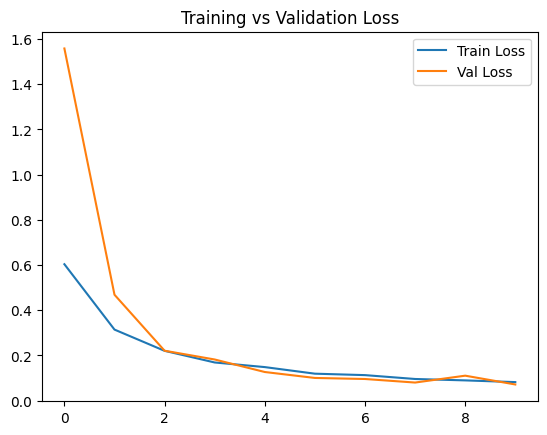

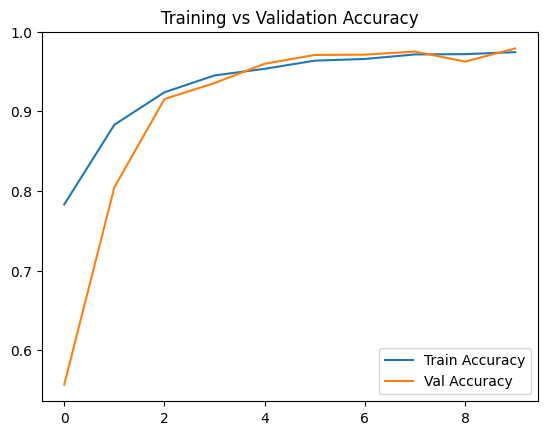

In [55]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()


In [56]:
# -------------------------
# 8) 평가 및 리포트
# -------------------------

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"테스트 손실: {test_loss:.4f} | 테스트 정확도: {test_acc:.4f}")

# 예측
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


테스트 손실: 0.0651 | 테스트 정확도: 0.9800
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       622
           1       1.00      0.99      0.99      2100
           2       0.98      0.94      0.96       373
           3       0.94      0.98      0.96       297
           4       0.94      0.95      0.95       767
           5       0.99      0.99      0.99      2607

    accuracy                           0.98      6766
   macro avg       0.96      0.97      0.97      6766
weighted avg       0.98      0.98      0.98      6766

[[ 588    1    1    0   28    4]
 [   1 2076    3    0   14    6]
 [   2    0  352   18    0    1]
 [   2    0    3  292    0    0]
 [  28    4    0    1  731    3]
 [   3    5    0    0    7 2592]]
